# Lab11-1: CNN
---
111062117 黃祥陞

In this assignment, you have to implement the input pipeline of the CNN model and try to write/read tfrecord with the Oregon Wildlife dataset.

## 0. Setup

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


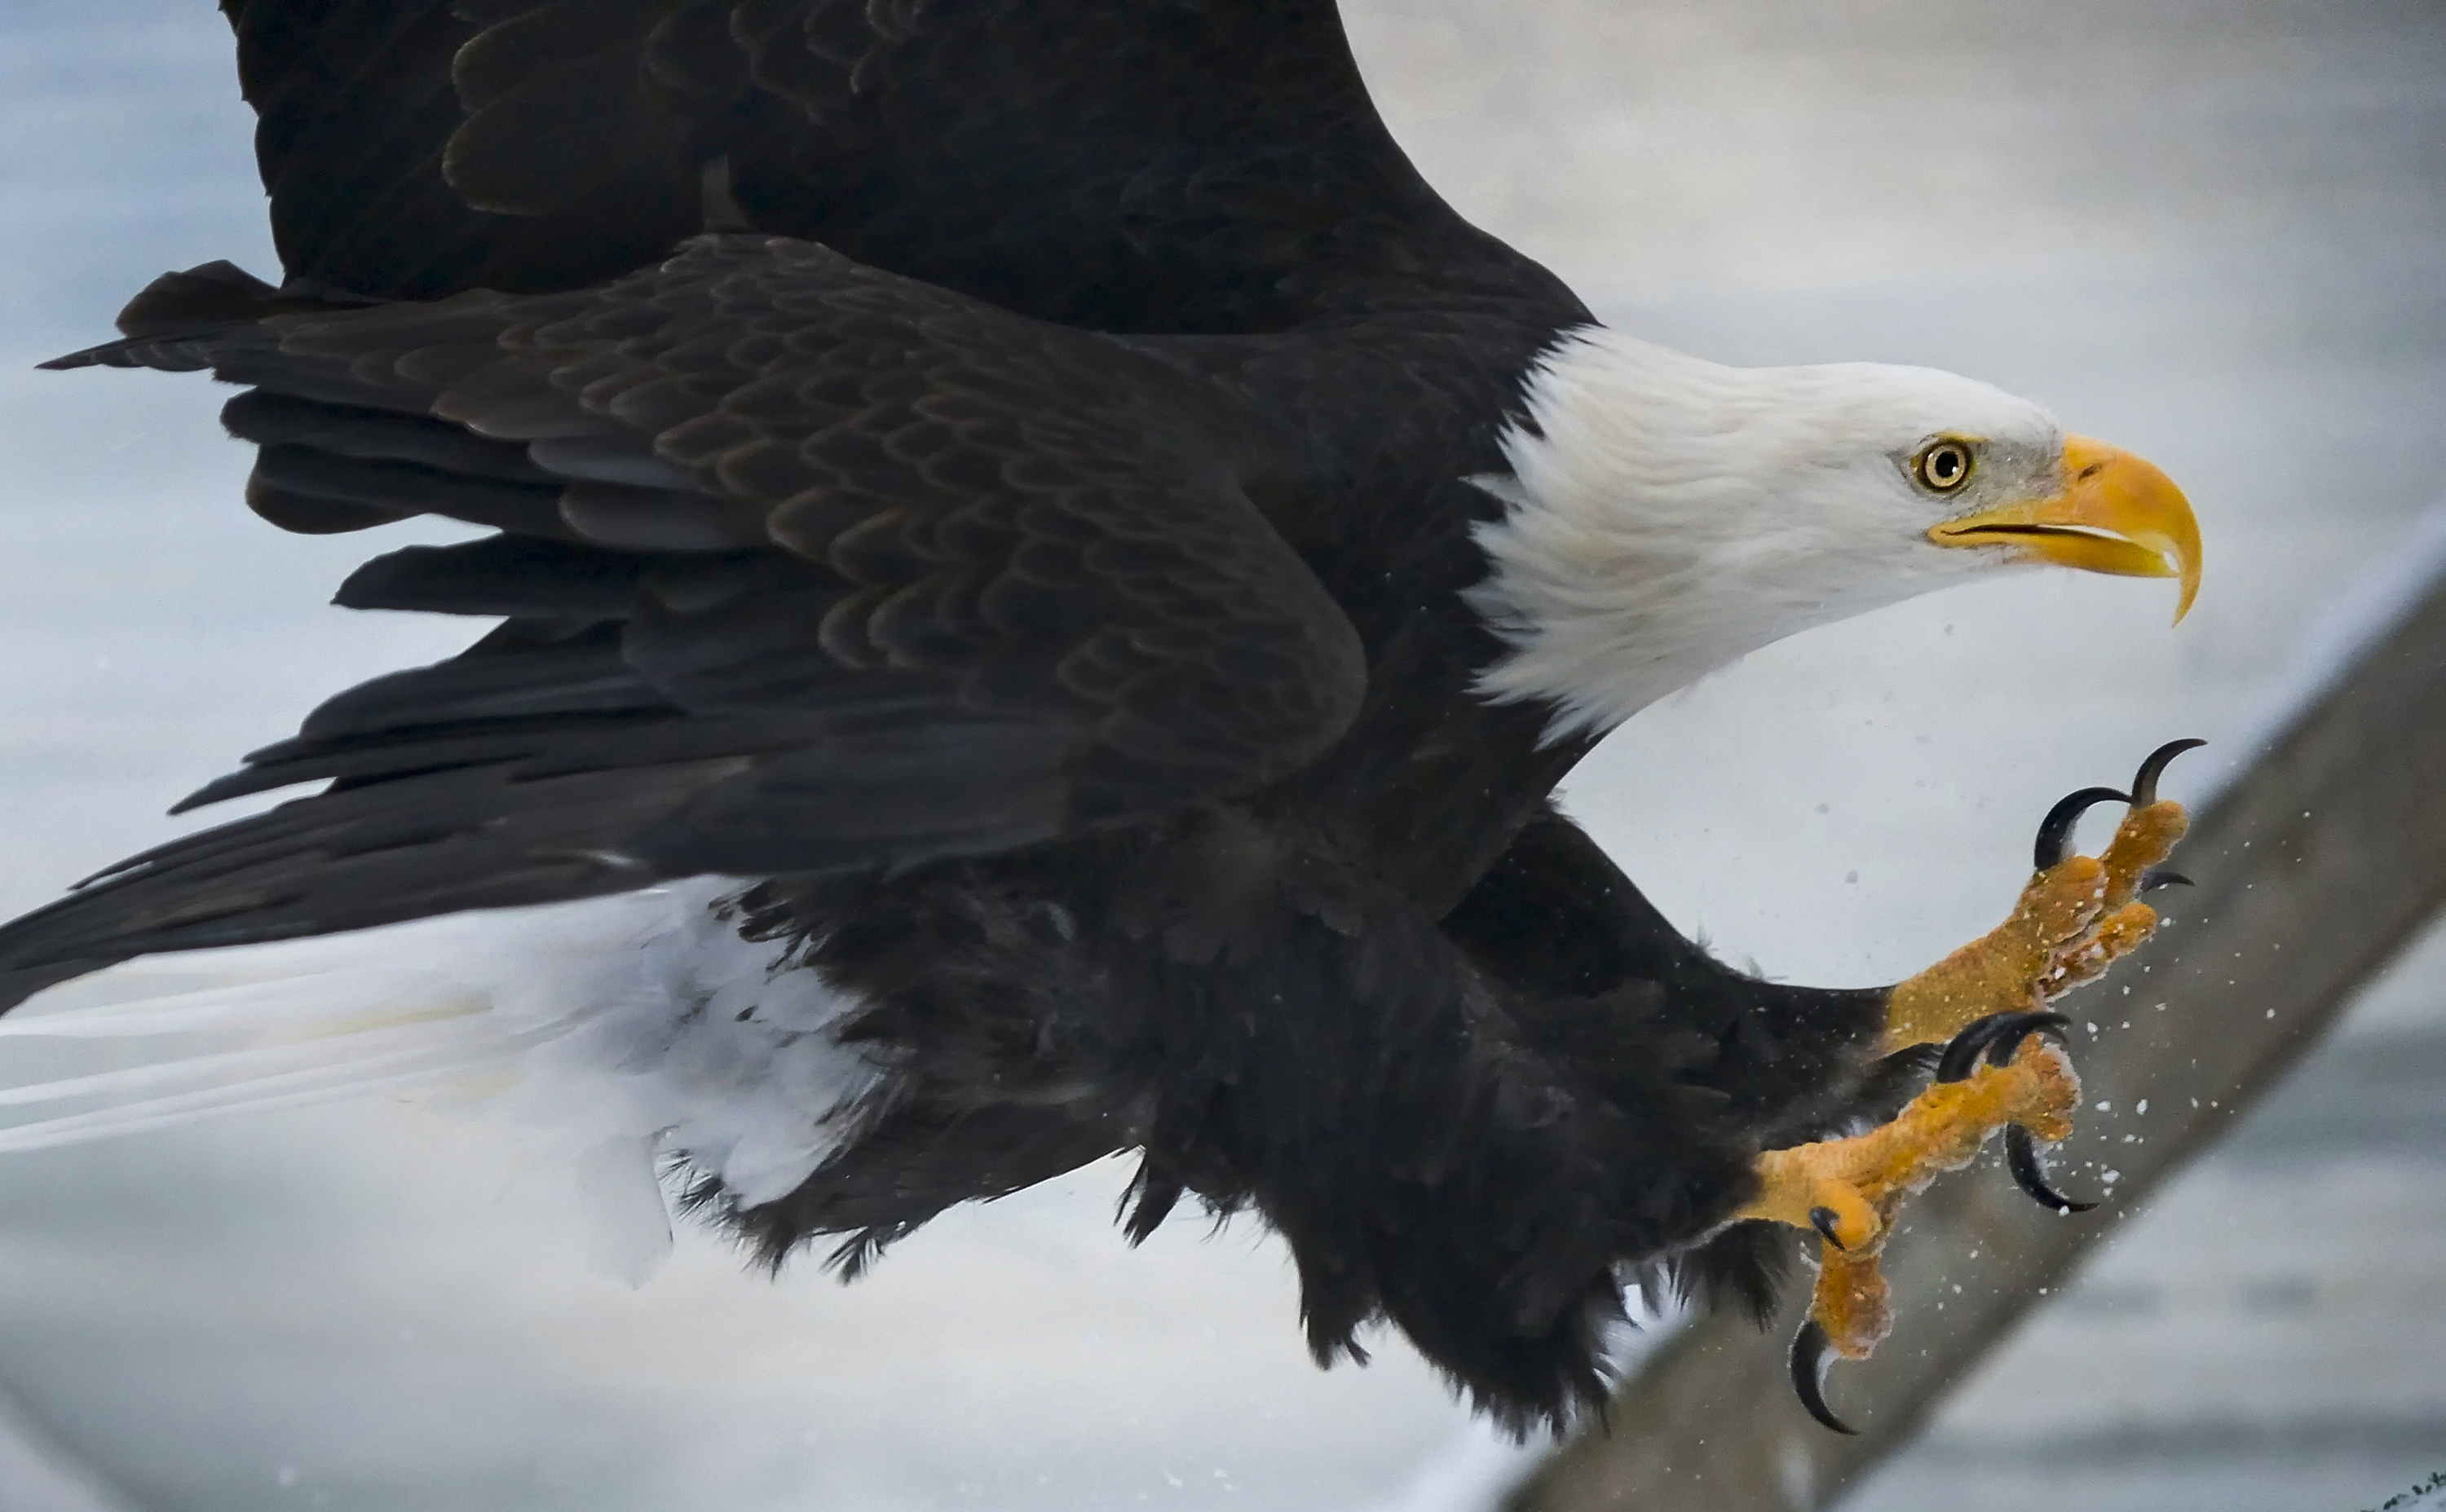

bald_eagle


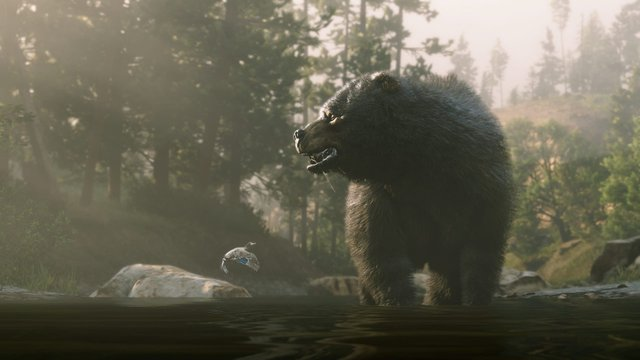

black_bear


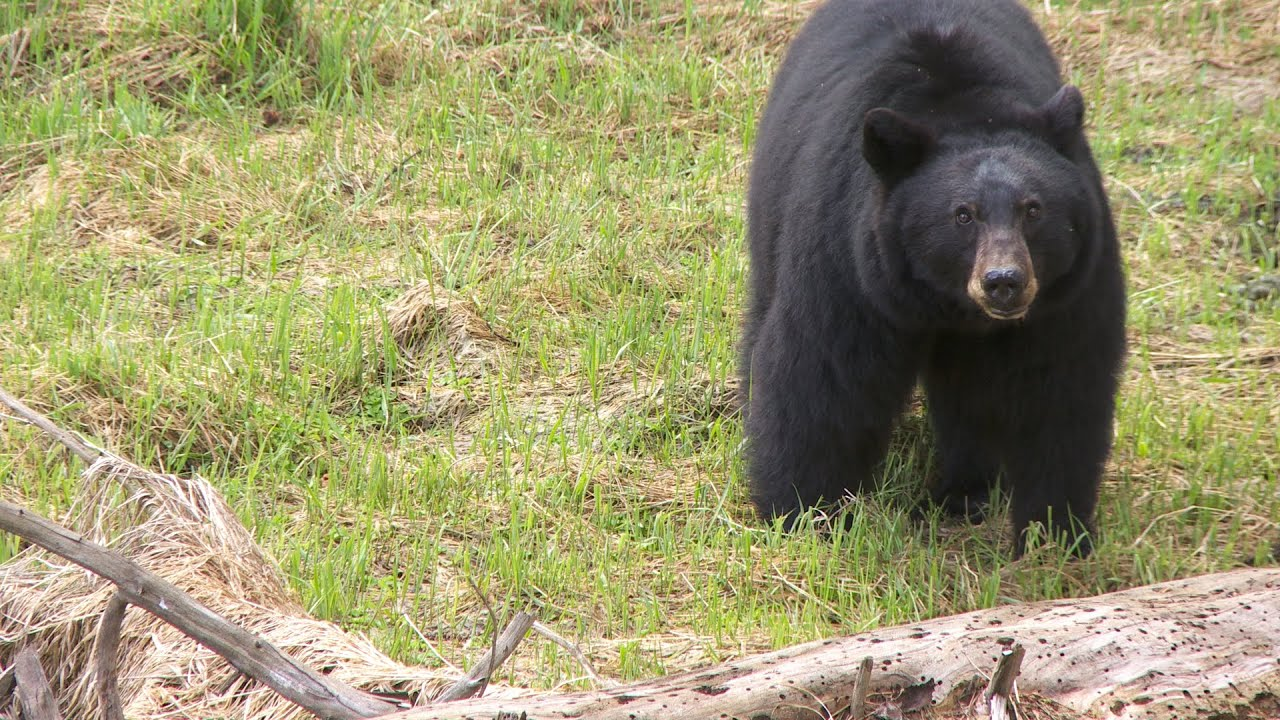

black_bear


In [2]:
data_root = pathlib.Path('./data/oregon_wildlife')
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)

label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
n_classes = len(label_names)

label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))

all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

print(label_to_index)
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [3]:
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

training data: 5734
testing data: 1434


In [4]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [5]:
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [6]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file        
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [7]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[5.138535e+00 4.292958e-03]
 [5.142829e+00 8.084709e-03]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


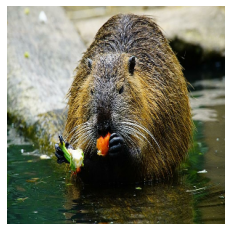

nutria


In [9]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [10]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [11]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [13]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [14]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [15]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  6.682369458
training:


100%|██████████| 89/89 [25:02<00:00, 16.88s/it]

testing:



100%|██████████| 22/22 [05:29<00:00, 14.97s/it]

Epoch 1, Loss: 5.5405, Accuracy: 24.5084, test Loss: 1.3416, test Accuracy: 59.7301
training:



100%|██████████| 89/89 [23:24<00:00, 15.78s/it]

testing:



100%|██████████| 22/22 [05:42<00:00, 15.55s/it]

Epoch 2, Loss: 1.1498, Accuracy: 59.1994, test Loss: 0.7318, test Accuracy: 78.8352
training:



100%|██████████| 89/89 [23:36<00:00, 15.91s/it]

testing:



100%|██████████| 22/22 [05:35<00:00, 15.24s/it]

Epoch 3, Loss: 0.8162, Accuracy: 71.9803, test Loss: 0.5472, test Accuracy: 84.4460
Execution time: 5329.1786694580005


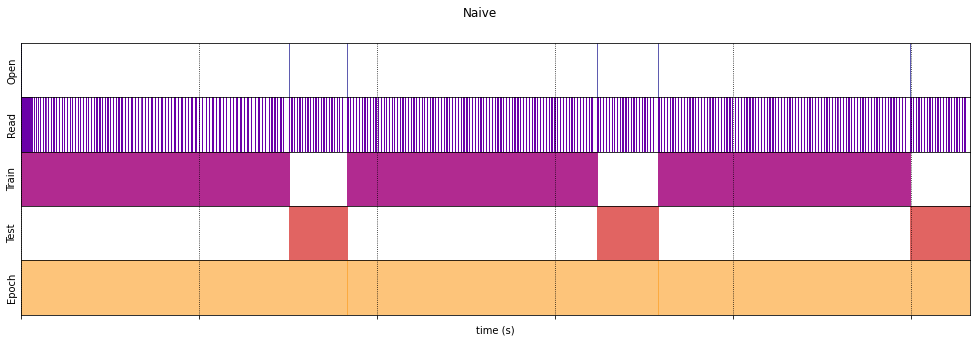

In [16]:
from lab11_1_lib import draw_timeline

draw_timeline(timeline=timeline_Naive, title="Naive", min_width=3000)

## 1. Try some input transformations mentioned above but without optimization terms

The `map_fun` function for training includes random flipping, brightness, and contrast adjustments, along with standardization.

The `map_fun_test` function applies only standardization to ensure consistency.

The datasets `dataset_train_augmentation` and `dataset_test_augmentation` use these transformations, with shuffling and batching applied to the training data.

In [17]:
@tf.function
def map_fun(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label

@tf.function
def map_fun_test(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.per_image_standardization(image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label

In [18]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions with map_decorator before calling map

dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                                     .shuffle(10000)\
                                                     .batch(BATCH_SIZE, drop_remainder=True)\
                                                     .map(map_fun)

dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                                    .batch(BATCH_SIZE, drop_remainder=True)\
                                                    .map(map_fun_test)

In [19]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

start time:  5337.536318458
training:


100%|██████████| 89/89 [24:05<00:00, 16.24s/it] 

testing:



100%|██████████| 22/22 [05:25<00:00, 14.79s/it]

Epoch 1, Loss: 6.5986, Accuracy: 51.3518, test Loss: 0.4008, test Accuracy: 88.9915
training:



100%|██████████| 89/89 [23:30<00:00, 15.85s/it] 

testing:



100%|██████████| 22/22 [05:23<00:00, 14.69s/it]

Epoch 2, Loss: 0.5087, Accuracy: 82.7949, test Loss: 0.2424, test Accuracy: 92.8977
training:



100%|██████████| 89/89 [23:38<00:00, 15.93s/it] 

testing:



100%|██████████| 22/22 [05:26<00:00, 14.84s/it]

Epoch 3, Loss: 0.3443, Accuracy: 88.8167, test Loss: 0.1983, test Accuracy: 94.4602
Execution time: 5249.230339958


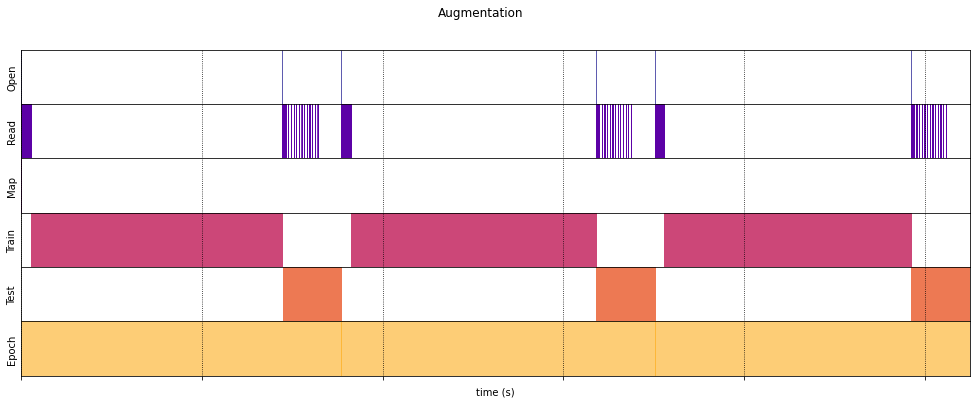

In [20]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=3000)

## 2. Retrain your model with optimized terms, comparing the performance and time consumption

The `dataset_train_optimized` and `dataset_test_optimized` datasets use `interleave`, `cache`, and `prefetch` to enhance data loading efficiency.

In [21]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated

dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .map(map_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

In [22]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

start time:  10588.833721875
training:


100%|██████████| 89/89 [23:27<00:00, 15.81s/it]

testing:



100%|██████████| 22/22 [05:35<00:00, 15.25s/it]

Epoch 1, Loss: 5.3568, Accuracy: 43.1706, test Loss: 0.4839, test Accuracy: 86.2216
training:



100%|██████████| 89/89 [23:18<00:00, 15.72s/it]

testing:



100%|██████████| 22/22 [05:26<00:00, 14.85s/it]

Epoch 2, Loss: 0.5449, Accuracy: 81.5836, test Loss: 0.2761, test Accuracy: 91.4773
training:



100%|██████████| 89/89 [23:15<00:00, 15.68s/it]

testing:



100%|██████████| 22/22 [05:28<00:00, 14.92s/it]

Epoch 3, Loss: 0.3177, Accuracy: 89.8701, test Loss: 0.2174, test Accuracy: 93.6080
Execution time: 5192.4035498329995


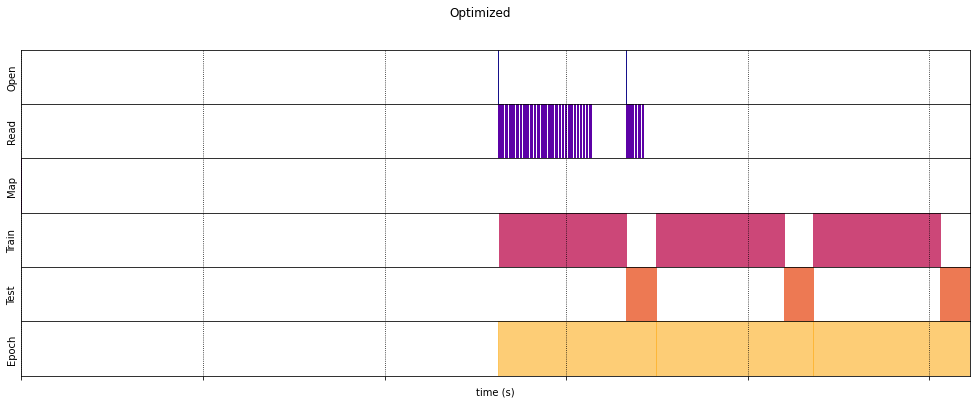

In [23]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=3000)

## 3. Training both models above for at least 3 epochs

As the results above show, the basic setup had the lowest accuracy. Applying transformations improved accuracy by augmenting the data, and further optimizing the data pipeline reduced training time significantly. This demonstrates that both data augmentation and efficient pipeline design can enhance model performance and training efficiency.

## 4. Briefly summarize what you did and explain the performance results (accuracy and time consumption)

| Model                     | Metric            | Epoch 1                  | Epoch 2                  | Epoch 3                  | Total Time (s)   |
|---------------------------|-------------------|--------------------------|--------------------------|--------------------------|------------------|
| Basic                     | Training Accuracy | 24.51%                   | 59.20%                   | 71.98%                   |                  |
|                           | Testing Accuracy  | 59.73%                   | 78.83%                   | 84.45%                   |                  |
|                           | Time Consumed (s) | 1831 s                   | 1746 s                   | 1751 s                   | 5329.18s         |
| Transformation            | Training Accuracy | 51.35%                   | 82.79%                   | 88.82%                   |                  |
|                           | Testing Accuracy  | 88.99%                   | 92.90%                   | 94.46%                   |                  |
|                           | Time Consumed (s) | 1770 s                   | 1733 s                   | 1744 s                   | 5249.23s         |
| Transformation + Pipeline | Training Accuracy | 43.17%                   | 81.58%                   | 89.87%                   |                  |
|                           | Testing Accuracy  | 86.22%                   | 91.48%                   | 93.61%                   |                  |
|                           | Time Consumed (s) | 1742 s                   | 1724 s                   | 1723 s                   | 5192.40s         |

From the results, we observe that:
- **Transformation**: Applying data transformations improved both training and testing accuracy significantly across all epochs compared to the basic setup. This indicates that data augmentation helped the model generalize better.
- **Transformation + Pipeline**: Adding an optimized data pipeline (using `interleave`, `cache`, and `prefetch`) provided some reduction in the overall training time, but the effect was not as significant as expected. This suggests that I/O speed may not be the primary bottleneck. Additionally, because the dataset is relatively small (7200 images), the advantages of caching and prefetching are less pronounced.

In conclusion, the transformation techniques improved the model's accuracy, while the optimized pipeline reduced training time slightly. However, the impact of `interleave`, `cache`, and `prefetch` was limited, likely because the training process was already efficient, and the dataset size did not lead to significant I/O delays.